In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [ ]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)

In [ ]:
# shuffle up the words before constructing dataset

import random
random.seed(42) 
random.shuffle(words)

In [97]:
# no. of character input for probs
block_size = 8

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix]
    
    return torch.tensor(X), torch.tensor(Y)

In [98]:
# divide dataset 80%, 10%, 10%

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
class Linear: 
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
        
        

In [141]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-05, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameter trained with backprop
        self.gemma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # running buffers - for inference(outside batch norm)
        self.running_mean = torch.zeros(dim) 
        self.running_var = torch.ones(dim) 
        
    def __call__(self, x):
        if(self.training):
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gemma * xhat + self.beta
        
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean # (exponential moving average ) - Temporal batch normalization
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar 
        return self.out
    
    def parameters(self):
        return [self.gemma, self.beta]    
        
        
class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [142]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

In [143]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [144]:
torch.manual_seed(42)

In [153]:
n_embd = 24 # 10 dim feature vector
n_hidden = 128 # hidden layer neuron counts in MLP


model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make last layer less confident(so we are not confidently wrong at initialization; avoid huge loss)
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in model.parameters():
    p.requires_grad = True
    

76579


In [155]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # construct a random mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    # Layers
    logits = model(Xb)
    
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # print loss
    if(i % 10000 == 0):
        print(f'iteration: {i}' , loss)
    
    # learning rate 
    lr = 0.01 if i > (max_steps / 2) else 0.1
    for p in parameters:
        p.data += -lr * p.grad
    
    lossi.append(loss.log10().item())

iteration: 0 tensor(2.0626, grad_fn=<NllLossBackward0>)
iteration: 10000 tensor(1.8466, grad_fn=<NllLossBackward0>)
iteration: 20000 tensor(1.9079, grad_fn=<NllLossBackward0>)
iteration: 30000 tensor(1.4249, grad_fn=<NllLossBackward0>)
iteration: 40000 tensor(1.4938, grad_fn=<NllLossBackward0>)
iteration: 50000 tensor(1.7876, grad_fn=<NllLossBackward0>)
iteration: 60000 tensor(1.9396, grad_fn=<NllLossBackward0>)
iteration: 70000 tensor(1.7013, grad_fn=<NllLossBackward0>)
iteration: 80000 tensor(1.8009, grad_fn=<NllLossBackward0>)
iteration: 90000 tensor(2.2651, grad_fn=<NllLossBackward0>)
iteration: 100000 tensor(2.1168, grad_fn=<NllLossBackward0>)
iteration: 110000 tensor(1.7965, grad_fn=<NllLossBackward0>)
iteration: 120000 tensor(2.0208, grad_fn=<NllLossBackward0>)
iteration: 130000 tensor(1.6693, grad_fn=<NllLossBackward0>)
iteration: 140000 tensor(1.8566, grad_fn=<NllLossBackward0>)
iteration: 150000 tensor(2.1765, grad_fn=<NllLossBackward0>)
iteration: 160000 tensor(1.6244, grad_

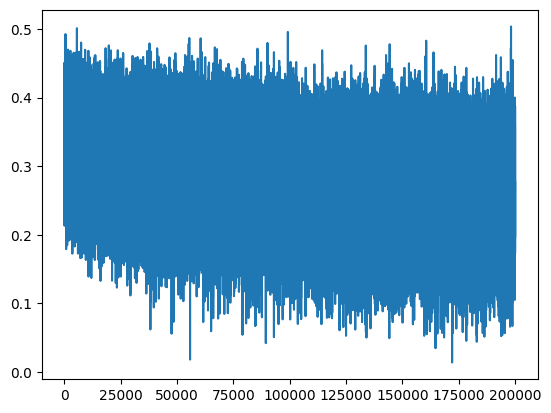

In [156]:
plt.plot(lossi)

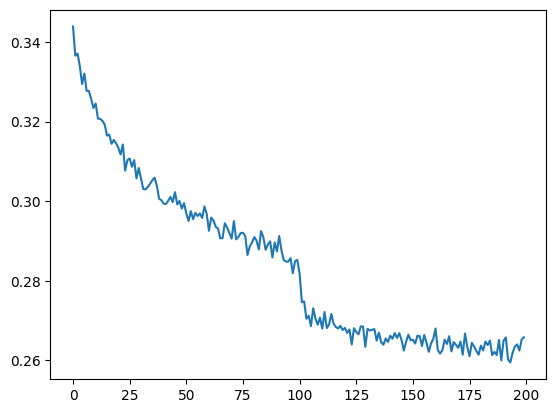

In [157]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [158]:
for layer in model.layers:
    layer.training = False

In [159]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    logits = model(x)
    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.806908130645752
val 1.9873251914978027


### performance log

- original (context 3) - 2.01
- v1(context 8) - 1.9
- (wavenet) - t(1.9836370944976807) v(2.0498428344726562)
- (batch norm fix) train 1.806908130645752 val 1.9873251914978027

In [160]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
       
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

christy.
rhylen.
caidyn.
nyesha.
grovara.
kaelynn.
mellahid.
olivana.
leuna.
orianda.
zydie.
belan.
kamber.
symdie.
kolt.
leighloni.
zan.
abriana.
athan.
fadia.
